In [9]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
df = pd.read_csv('apartments.csv')
df

,title,area,price,rooms,floor,square-meter,elevator,air-condition,refurbished,furniture
0,י.ל. פרץ 38,south,"6,300 ₪",3.0,5,100,True,True,True,False
1,נווה שאנן,south,"5,700 ₪",3.0,4,57,True,True,True,False
2,דרך קיבוץ גלויות 113,south,"3,200 ₪",1.0,קרקע,25,False,True,True,False
3,השכל 5,south,"3,500 ₪",2.0,1,40,False,True,False,True
4,הרטוב 18,south,"6,000 ₪",4.0,1,90,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...
86,נתן הנביא,south,"1,500 ₪",1.0,קרקע,30,False,True,False,False
87,כרם חמד 6,south,"5,000 ₪",4.0,2,75,False,True,False,True
88,לוינסקי 63,south,"4,000 ₪",1.0,קרקע,20,False,True,True,True
89,ראש פינה 24,south,"5,400 ₪",3.0,1,71,True,True,False,True


(array([39., 25., 20.,  4.,  1.,  0.,  0.,  0.,  0.,  2.]),
 array([ 15. ,  46.5,  78. , 109.5, 141. , 172.5, 204. , 235.5, 267. ,
        298.5, 330. ]),
 <a list of 10 Patch objects>)

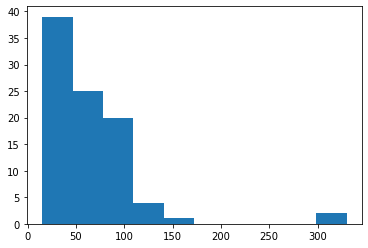

In [13]:
plt.hist(df['square-meter'])

In [14]:
df[df['square-meter'] > 250]

,title,area,price,rooms,floor,square-meter,elevator,air-condition,refurbished,furniture
80,גבעת בן יהודה 10,south,לא צוין מחיר,7.0,קרקע,300,False,True,True,False
90,בעל העקידה,south,"14,000 ₪",6.0,קרקע,330,False,True,True,False


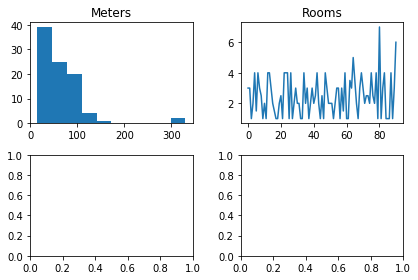

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2)

axes[0, 0].hist(df['square-meter'])
axes[0, 0].set_title('Meters')
axes[0, 1].plot(df['rooms'])
axes[0, 1].set_title('Rooms')

plt.tight_layout()